In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preparing the data

In this assignment, we are going to make use of the following 4 explanatory variables that can possibly explain the movement of any US stock, moving average of the nasdaq index, rolling volatility of nasdaq, federal interest rate and mortgage loan rates. The federal interest rate and mortgage loan rates are retrieved from Quandl.com.

## Moving Average and Rolling Volatility 

In [2]:
start_date = '2014-05-08'
end_date = '2020-05-08'

inner_start = '2017-01-01'
inner_end = '2017-10-01'

nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False).rename(columns={'Adj Close': 'Adj_Close'})
nasdaq.sort_index(inplace=True)

ma = nasdaq.Adj_Close.rolling(window=50).mean().fillna(method='pad')
vol = nasdaq.Adj_Close.rolling(window=50).std().fillna(method='pad')

## Federal Interest Rate

In [3]:
# Read federal interest rate
rates = pd.read_csv("FRED-DTB3.csv") 
rates['Date'] = pd.to_datetime(rates['Date'])  
mask = (rates['Date'] > inner_start) & (rates['Date'] <= inner_end)
rates = rates.loc[mask]
# Read mortgage loan rate
mortgage_rates = pd.read_csv("mortgage.csv") 
mortgage_rates['Date'] = pd.to_datetime(mortgage_rates['Date'])  
mask = (mortgage_rates['Date'] > inner_start) & (mortgage_rates['Date'] <= inner_end)
mortgage_rates = mortgage_rates.loc[mask]

# Cleaning and formatting the data

After we load all the data required, we need to do some formatting. Firstly, we need to restrict the data to only a time period which we will be using to train the model. In this case, we will be using a 10-month period from 2017-01-01 to 2017-10-01.

Additionally, because not all the dates will be consistent among the different data sources, we need to filter all 4 datasets such that every dataset will contain exactly the same dates.

Finally, we have to scale each dataset to prevent biasness as the dataset with larger values will dominate over the others. We will be using the StandardScaler for this.

In [4]:
ma_windowed = ma.loc[(ma.index > inner_start) & (ma.index <= inner_end)]
vol_windowed = vol.loc[(vol.index > inner_start) & (vol.index <= inner_end)] 

filtered_mortgage_rates = mortgage_rates[mortgage_rates['Date'].isin(ma_windowed.index)]
filtered_ma = ma_windowed[ma_windowed.index.isin(mortgage_rates['Date'])]
filtered_vol = vol_windowed[vol_windowed.index.isin(mortgage_rates['Date'])]
filtered_rates = rates[rates['Date'].isin(mortgage_rates['Date'])]

train = np.empty([4, len(filtered_mortgage_rates)])

train[0] = StandardScaler().fit_transform(filtered_ma.values.reshape(-1, 1))[:, 0]
train[1] = StandardScaler().fit_transform(filtered_vol.values.reshape(-1, 1))[:, 0]
train[2] = StandardScaler().fit_transform(filtered_rates['Value'].values.reshape(-1, 1))[:, 0]
train[3] = StandardScaler().fit_transform(filtered_mortgage_rates['Value'].values.reshape(-1, 1))[:, 0]

# Fitting the data to PCA

Now, we are ready to fit our 4 datasets to a PCA to analyse the principal components. The 4 components are joined together in a matrix and transposed. The resulting matrix consists of n number of rows with 4 columns. Each row refers to a specific time in the time series, while each of the 4 columns represents the data from each respective dataset of explanatory variables.

After fitting with PCA, the plot of the explained variance ratio of each principal component is shown below.

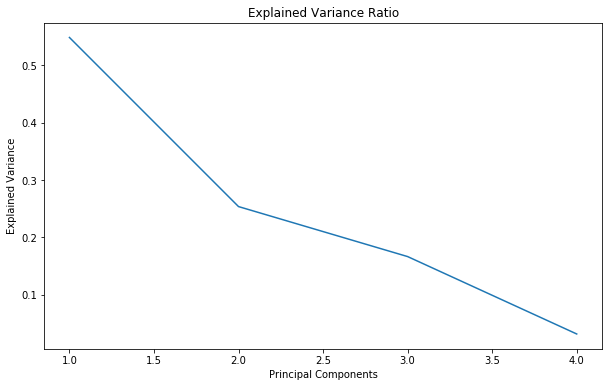

In [5]:
transposed_train = train.T

# Fit PCA
pca = PCA(n_components=4)
pca.fit(transposed_train)
reduced_data = pca.transform(transposed_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 5), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()

From the graph, we see that the first pricinpal component explains about 55% of the variation, while the second principal component explains about 25%. We can then transform each of the original data by projecting them onto each of the principal components. The plot of the series on each projected component is then shown in the diagram below.

In [6]:
projected_pc1 = reduced_data[:,0]
projected_pc2 = reduced_data[:,1]
projected_pc3 = reduced_data[:,2]
projected_pc4 = reduced_data[:,3]

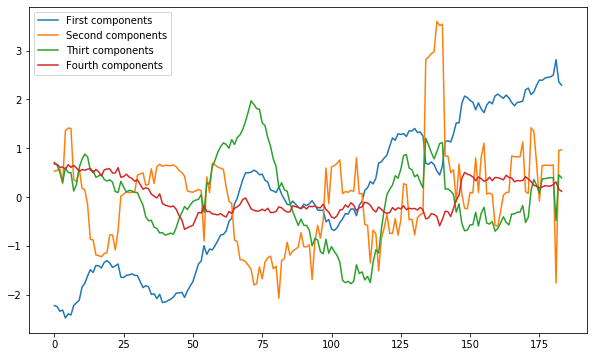

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(projected_pc1, label='First components')
plt.plot(projected_pc2, label='Second components')
plt.plot(projected_pc3, label='Thirt components')
plt.plot(projected_pc4, label='Fourth components')
plt.legend(loc='best');

The blue line refers to the first principal component while the orange line refers to the second principal component. We can see that the blue line captures the long term drift, while the orange line, which is mean-reverting, captures the variance.

We are now ready to use the principal components for training a machine learning model for trading. By utilising only the first 2 pricinpal components for training, we can already retain 80% of the information and reduce the number of dimensions by half.